In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns

In [2]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [3]:
def get_rnd_wm_samples(env, num_rollouts):
    old_obs = []
    actions = []
    new_obs = []
    for _ in range(num_rollouts):
        
        observation, info = env.reset()
        
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
            obs = observation
    
            action = env.action_space.sample()
        
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            old_obs.append(obs)
            actions.append(action)
            new_obs.append(observation)
       
        # Once the episode is done, close the environment
        env.close()
    
    old_obs = np.vstack(old_obs)
    actions = np.vstack(actions)
    new_obs = np.vstack(new_obs)

    inputs = np.concatenate((old_obs, actions), axis=1)

    return inputs, new_obs

# Docs
Okay, just try verbatim what they're doing and see if it helps

data_x.shape:  (1, 400, 2)
data_y.shape:  (1, 400, 1)


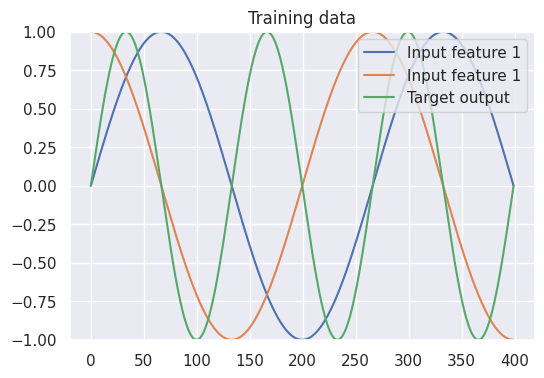

In [8]:
import matplotlib.pyplot as plt

N = 400 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)

data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [5]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


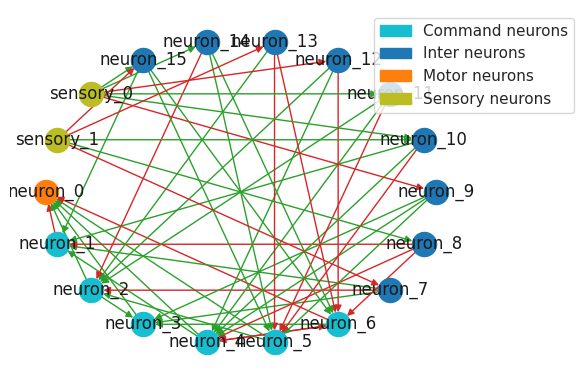

In [6]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()# Let's visualize how LTC initialy performs before the training
sns.set()

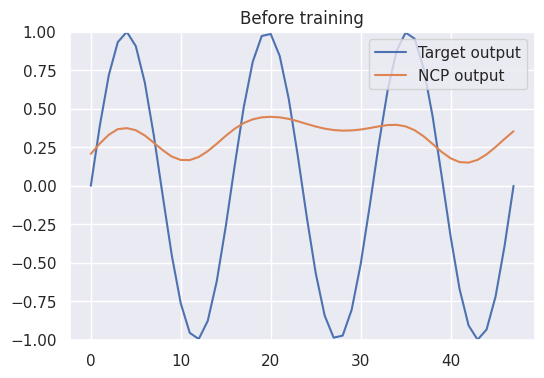

In [6]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [7]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.0 K  | train
---------------------------------------
848       Trainable params
196       Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/tristongrayston/.local/lib/python3.10/s

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


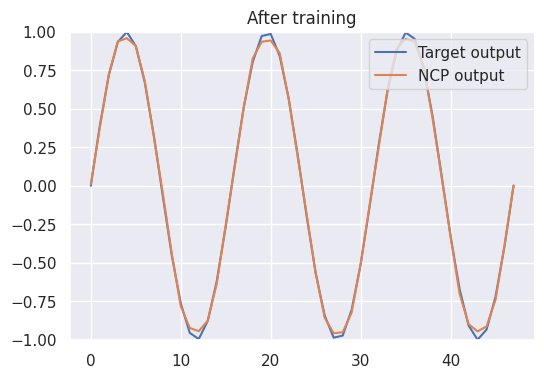

In [8]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# Docs, modified for temporal data.

In [375]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

    def training_step(self, batch, batch_idx):
        ''' This is with the assumption that the batches will come in of something like 
        batch = (x, y) where x and y both have shape
        shape=(batch_size, trajectory_length, input_space)'''
        x, y = batch
        trajectory = []
        hid = torch.zeros((x.shape[0], self.model.state_size)).to("cuda:0")
        y_hat = x 
        
        for i in range(self.length):
            y_hat, hid = self.model.forward(y_hat, hid)
            trajectory.append(y_hat)

        trajectory = torch.squeeze(torch.stack(trajectory, dim=1), dim=0)
        #print(trajectory.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        #print(y.shape)
        #loss = torch.abs(trajectory - y)
        
        loss = nn.MSELoss()(trajectory, y)
        #print(loss.shape)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [ ]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

    def training_step(self, batch, batch_idx):
        ''' This is with the assumption that the batches will come in of something like 
        batch = (x, y) where x and y both have shape
        shape=(batch_size, trajectory_length, input_space)'''
        x, y = batch
        trajectory = []
        hid = torch.zeros((x.shape[0], self.model.state_size)).to("cuda:0")
        y_hat = x 
        
        for i in range(self.length):
            y_hat, hid = self.model.forward(y_hat, hid)
            trajectory.append(y_hat)

        trajectory = torch.squeeze(torch.stack(trajectory, dim=1), dim=0)
        #print(trajectory.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        #print(y.shape)
        #loss = torch.abs(trajectory - y)
        
        loss = nn.MSELoss()(trajectory, y)
        #print(loss.shape)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [376]:
import matplotlib.pyplot as plt

N = 10000 # Length of the time-series
# Input feature is a sine and a cosine wave

data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)

#data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
#data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)



print("data_x.shape: ", str(data_x.shape))
#print("data_y.shape: ", str(data_y.shape))

data_x.shape:  (10000, 2)


In [377]:
x = []
y = []
traj_len = 10
for i in range(N//traj_len - 1):
    x.append(data_x[i])
    #seq = data_x[i*traj_len+1:i*traj_len+1+traj_len]
    y.append(data_x[i*traj_len+1:i*traj_len+1+traj_len])
    #print(seq.shape)

#print(x, y[0])
#print(" ")
#print(x, y[1])
x = np.stack(x)
y = np.stack(y)

x = np.expand_dims(x, axis=1)

In [378]:
data_x = torch.Tensor(x)
data_y = torch.Tensor(y)

In [379]:
print(data_x.shape, " ", data_y.shape)

torch.Size([999, 1, 2])   torch.Size([999, 10, 2])


In [380]:
from ncps.wirings import NCP

out_features = 2
in_features = 2

wiring = NCP(inter_neurons=4, command_neurons=4, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=4, recurrent_command_synapses=3, motor_fanin=3)

ltc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = MultiStepSeqLearner(ltc_model, lr=0.01, length=traj_len)

trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=100,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


(5, 1, 2)


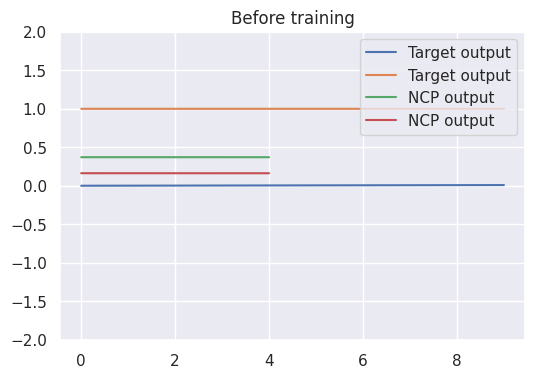

In [381]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x[:5])[0].numpy()

print(prediction.shape)
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, :], label="Target output")
plt.plot(prediction[:,0, :], label="NCP output")
plt.ylim((-2, 2))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [382]:
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

#dir(dataloader[0])

In [383]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 380    | train
---------------------------------------
312       Trainable params
68        Non-trainable params
380       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [384]:
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)

#data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
#data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
data_x = torch.Tensor(data_x)
data_x.shape

torch.Size([10000, 2])

(10, 2)


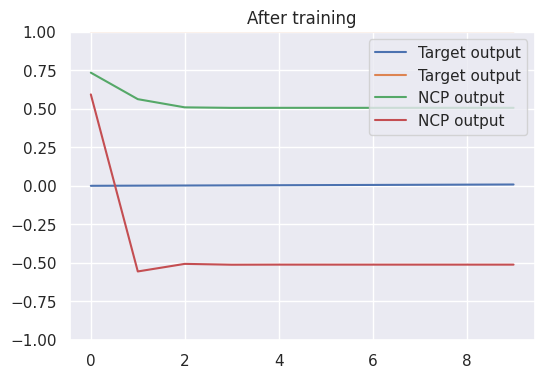

In [385]:
# How does the trained model now fit to the sinusoidal function?
sns.set()

predictions = []

#inputs = data_x[0:1]
#print(inputs.shape)
with torch.no_grad():
    prediction, h = ltc_model(data_x[0:1])
predictions.append(prediction.numpy())

for i in range(9):
    with torch.no_grad():
        prediction, h = ltc_model(prediction)
    predictions.append(prediction.numpy())
    
predictions = np.squeeze(np.stack(predictions), axis=1)
print(predictions.shape)
plt.figure(figsize=(6, 4))
plt.plot(data_x[:10], label="Target output")
plt.plot(predictions[:], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

torch.Size([10000, 2])
(9999, 2)


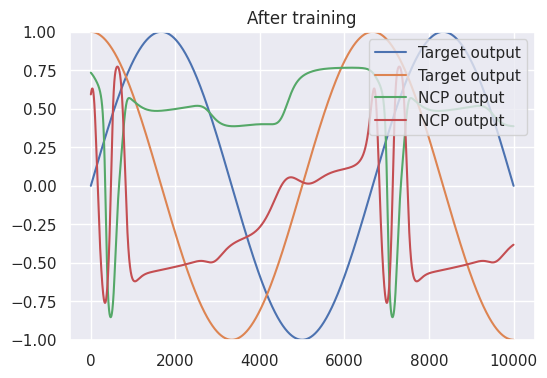

In [386]:
# How does the trained model now fit to the sinusoidal function?

predictions = []
print(data_x.shape)
for i in range(data_x.shape[0]-1):
    with torch.no_grad():
        prediction, h = ltc_model(data_x[i:i+1])
        predictions.append(prediction)

predictions = np.squeeze(np.stack(predictions), axis=1)
print(predictions.shape)
plt.figure(figsize=(6, 4))
plt.plot(data_x, label="Target output")
plt.plot(predictions, label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# Test 2: Lotka–Volterra Predator–Prey Model

In [9]:
a = 1.1
b = 0.4 
g = 0.4
d = 0.1

y0 = [10, 1]
time = np.linspace(0, 50, 100)
params = (a, b, d, g)

In [10]:
def sim(variables, time, params):
    x = variables[0] # prey pop level
    y = variables[1] # pred pop level

    a, b, d, g = params
    
    dxdt = a*x - b*x*y
    dydt = d*x*y - g*y

    return [dxdt, dydt]

In [11]:
from scipy.integrate import odeint
y = odeint(sim, y0, time, args=(params,))
y = [y[:, 0] + (0.5**0.5)*np.random.normal(0, 0.5, (100,)), y[:, 1] + (0.5**0.5)*np.random.normal(0, 0.5, (100,))] 

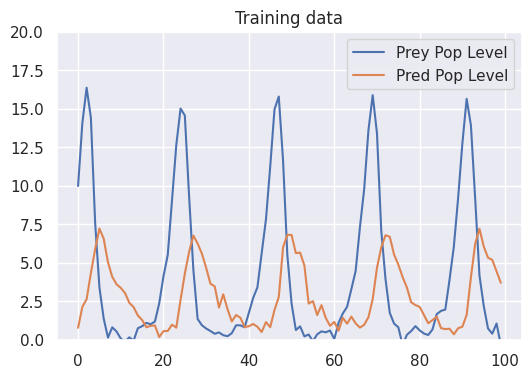

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(y[0], label="Prey Pop Level")
plt.plot(y[1], label="Pred Pop Level")
#plt.plot(y[:, 1] + y[:, 0], label="Total Population")
plt.ylim((0, 20))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [14]:
# Make batches

def batchify(data_x, data_y, input_timesteps=1):
    inputs = []
    outputs = []
    for i in range(len(data_x) - 1):
        inputs.append(torch.tensor([data_x[i], data_y[i]], dtype=torch.float32))
        outputs.append(torch.tensor([data_x[i+1], data_y[i+1]], dtype=torch.float32))

    inputs = torch.stack(inputs)
    outputs = torch.stack(outputs)
    return inputs, outputs

data_x, data_y = batchify(y[0], y[1])
data_y.shape

torch.Size([99, 2])

In [15]:
print(data_x.shape)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

torch.Size([99, 2])


In [21]:
out_features = 2
in_features = 2

wiring = AutoNCP(32, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


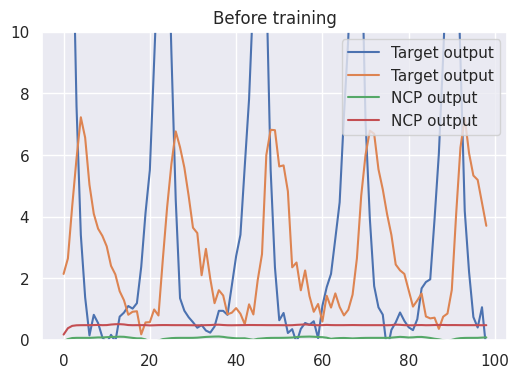

In [22]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y, label="Target output")
plt.plot(prediction, label="NCP output")
plt.ylim((0, 10))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [23]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 5.5 K  | train
---------------------------------------
4.5 K     Trainable params
1.1 K     Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


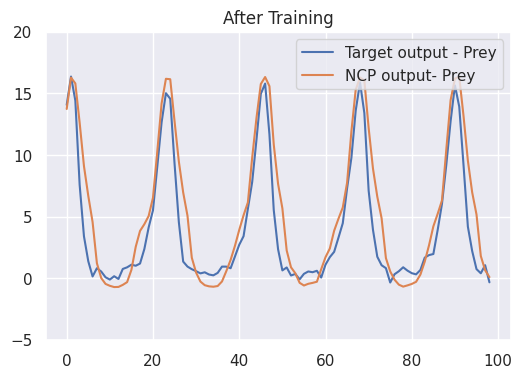

In [24]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output - Prey")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 0], label="NCP output- Prey")
plt.ylim((-5, 20))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

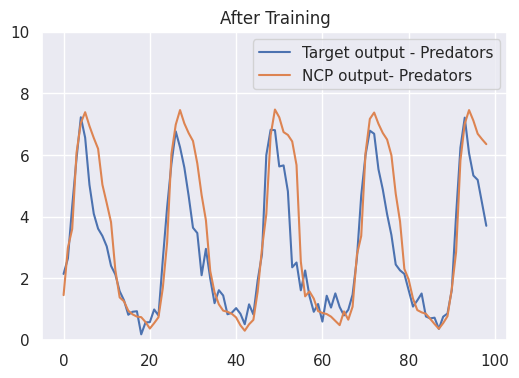

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 1], label="Target output - Predators")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 1], label="NCP output- Predators")
plt.ylim((-0, 10))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

:(

In [36]:
# Now for CFC:
out_features = 2
in_features = 2

wiring = AutoNCP(32, out_features)  # 16 units, 1 motor neuron

cfc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(cfc_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 3.9 K  | train
---------------------------------------
3.1 K     Trainable params
748       Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


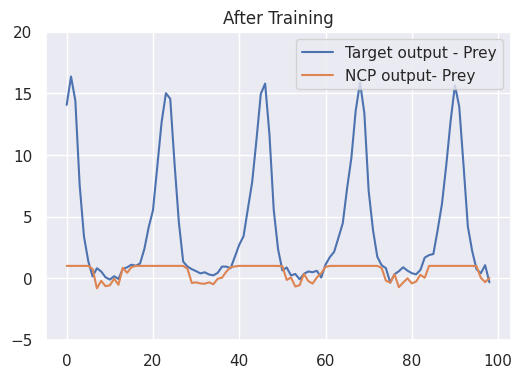

In [40]:
sns.set()
with torch.no_grad():
    prediction = cfc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output - Prey")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 0], label="NCP output- Prey")
plt.ylim((-5, 20))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

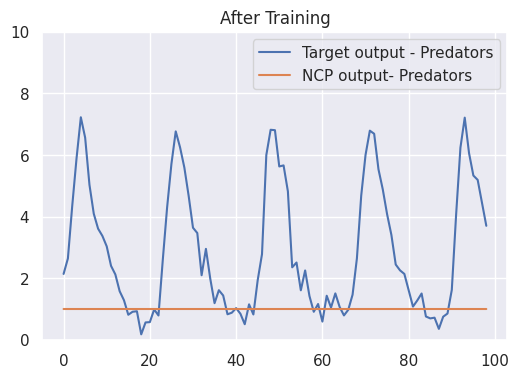

In [41]:
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 1], label="Target output - Predators")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 1], label="NCP output- Predators")
plt.ylim((-0, 10))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

Okay, now let's see if we can get a world model out of this

# Liquid World Model

In [10]:
import gym
num_rollouts = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")


In [11]:
old_obs = []
actions = []
new_obs = []
for _ in range(num_rollouts):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        old_obs.append(obs)
        actions.append(action)
        new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

old_obs = np.vstack(old_obs)
actions = np.vstack(actions)
new_obs = np.vstack(new_obs)

In [12]:
old_obs.shape

(20000, 3)

In [13]:
inputs = np.concatenate((old_obs, actions), axis=1)
inputs.shape

(20000, 4)

In [14]:
inputs = torch.tensor(inputs)
outputs = torch.tensor(new_obs)
dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=64, shuffle=True, num_workers=4
)

In [15]:
out_features = 3
in_features = 4

wiring = AutoNCP(64, out_features)  

world_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=25,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 22.0 K | train
---------------------------------------
17.6 K    Trainable params
4.4 K     Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=25` reached.


So for the purposes of visualization, what do we want to see? What metrics would we like to know?

We can create a validation set by running a new rollout for pendulum and check for the loss.

In [17]:
t_old_obs = []
t_actions = []
t_new_obs = []
for _ in range(1):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        t_old_obs.append(obs)
        t_actions.append(action)
        t_new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

t_old_obs = np.vstack(t_old_obs)
t_actions = np.vstack(t_actions)
t_new_obs = np.vstack(t_new_obs)
t_old_obs.shape

(200, 3)

In [18]:
test_inputs = np.concatenate((t_old_obs, t_actions), axis=1)
test_inputs.shape
test_inputs = torch.tensor(test_inputs)

In [19]:
with torch.no_grad():
    prediction = world_model(test_inputs)[0].numpy()

prediction.shape

(200, 3)

In [20]:
# residual plot

predictions = prediction[:, 0:2]
true = t_new_obs[:, 0:2]
residuals = predictions - true
axis_avg = np.abs(np.average(residuals, axis=1))
axis_avg.shape

(200,)

Text(0.5, 1.0, 'One Step Prediction Absolute Co-ordinate Loss (Liquid World Model)')

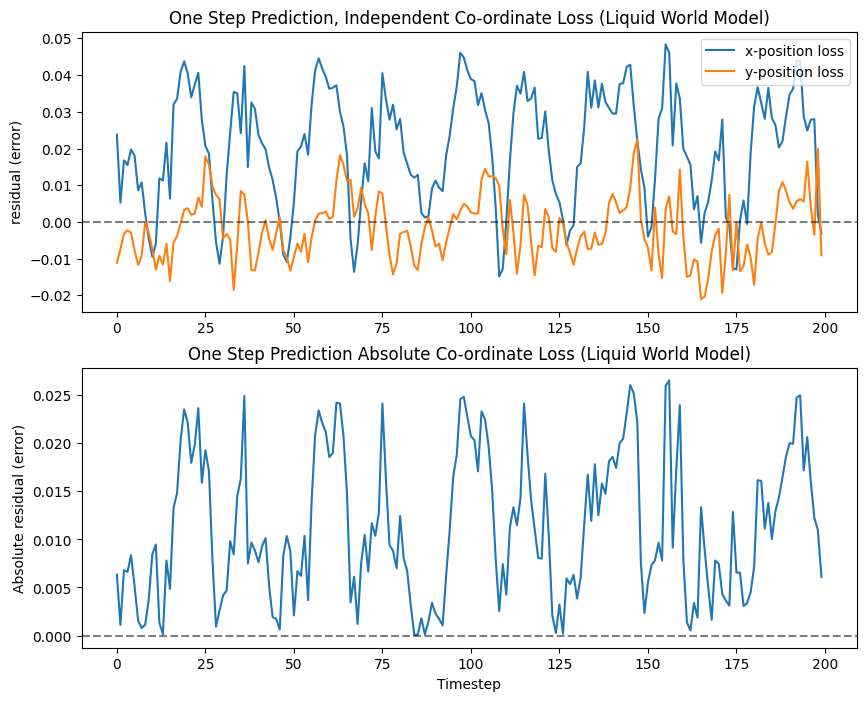

In [21]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(residuals[:, 0], label="x-position loss")
ax[0].plot(residuals[:, 1], label="y-position loss")
ax[0].legend()
ax[0].axhline(0,ls='--',c='k',alpha=0.5)
ax[0].set_ylabel('residual (error)')
#plt.colorbar(panel,ax=ax[i],label='Q pred')

ax[1].plot(axis_avg)
ax[1].axhline(0,ls='--',c='k',alpha=0.5)
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Absolute residual (error)')

ax[0].set_title("One Step Prediction, Independent Co-ordinate Loss (Liquid World Model)")
ax[1].set_title("One Step Prediction Absolute Co-ordinate Loss (Liquid World Model)")

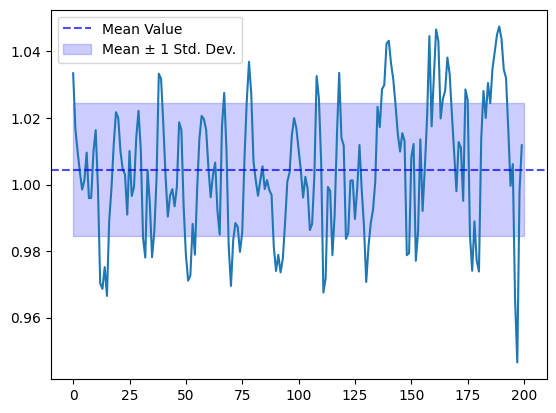

In [22]:
# For sanity check reasons, we can also test how far away the two datapoints are from 1.

predictions_x = predictions[:, 0]
predictions_y = predictions[:, 1]

radius = predictions_x**2 + predictions_y**2

mean=np.mean(radius)
std = np.std(radius)

x = np.linspace(0, 200, 200)

# y1 is the lower bound (mean-std), y2 is the upper bound (mean+std)
y_lower = np.full_like(x, mean - std)  # array of shape (100,)
y_upper = np.full_like(x, mean + std)  # array of shape (100,)


plt.plot(radius)
plt.axhline(mean, ls='--',c='blue',alpha=0.7, label="Mean Value")

plt.fill_between(
    x,
    y_lower,
    y_upper,
    color='blue',
    alpha=0.2,
    label='Mean ± 1 Std. Dev.'
)
plt.legend()

Now as a measure of expressiveness, lets see the error on our world model if we go past one step prediction. 

In [23]:
test_outputs = []
test_horizon = [test_inputs[0]]

for i in range(t_actions.shape[0] - 1):
    inputs = test_horizon[i].view(1, -1)
    with torch.no_grad():
        prediction = world_model(inputs)[0].numpy()
    # append prediction
    test_outputs.append(prediction)

    new_action = np.expand_dims(np.array(t_actions[i+1]), axis=0)
    # append output with action
    new_horizon = np.concatenate((prediction, new_action), axis=1)
    test_horizon.append(torch.tensor(new_horizon))
    

In [24]:
horizon_predictions = np.vstack(test_outputs)

In [25]:
print(type(horizon_predictions))

<class 'numpy.ndarray'>


In [26]:
predictions = horizon_predictions[:, 0:2]
true = t_new_obs[:-1, 0:2]
residuals = predictions - true
axis_avg = np.abs(np.average(residuals, axis=1))
axis_avg.shape

(199,)

Text(0, 0.5, 'Absolute residual (error)')

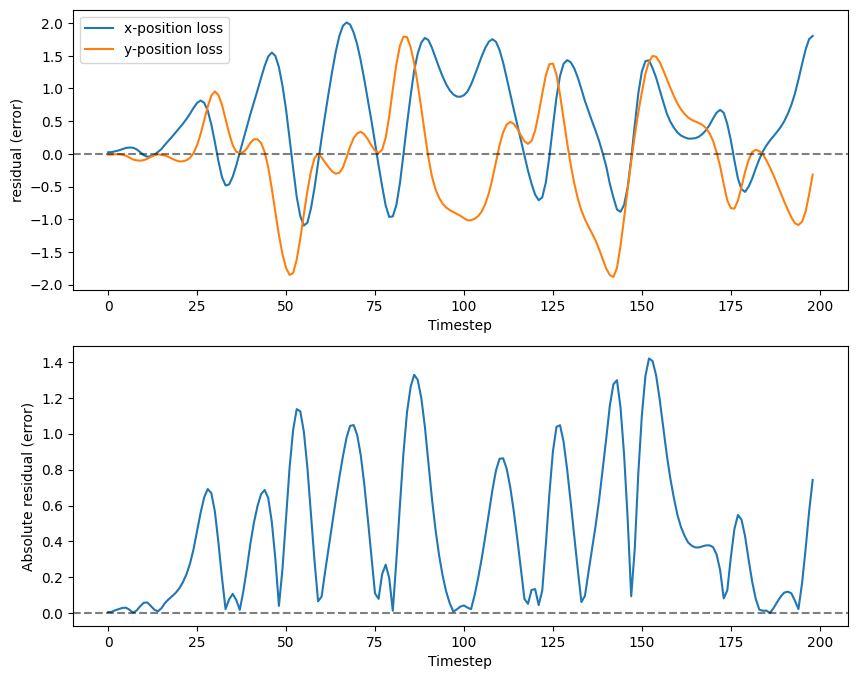

In [27]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(residuals[:, 0], label="x-position loss")
ax[0].plot(residuals[:, 1], label="y-position loss")
ax[0].legend()
ax[0].axhline(0,ls='--',c='k',alpha=0.5)
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('residual (error)')
#plt.colorbar(panel,ax=ax[i],label='Q pred')

ax[1].plot(axis_avg)
ax[1].axhline(0,ls='--',c='k',alpha=0.5)
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Absolute residual (error)')

In [28]:
# Okay, now we can maybe get some means and error bars for the expressiveness of our world model as dictated by trajectory length
t_old_obs = []
t_actions = []
t_new_obs = []
for _ in range(1):    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        t_old_obs.append(obs)
        t_actions.append(action)
        t_new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

t_old_obs = np.vstack(t_old_obs)
t_actions = np.vstack(t_actions)
t_new_obs = np.vstack(t_new_obs)

test_inputs = np.concatenate((t_old_obs, t_actions), axis=1)
test_inputs = torch.tensor(test_inputs)

t_old_obs.shape

(200, 3)

In [29]:
set_of_residuals = []

for j in range(150-1):
    test_horizon = [test_inputs[j]]
    rollout_residuals = []
    
    for i in range(50):
        inputs = test_horizon[i].view(1, -1)
        with torch.no_grad():
            prediction = world_model(inputs)[0].numpy()

        # get residuals
        residuals = np.abs(np.average(prediction[:, :2] - t_new_obs[j + i, :2], axis=1))
        rollout_residuals.append(residuals)
    
        new_action = np.expand_dims(np.array(t_actions[j + i+1]), axis=0)
        # append output with action
        new_horizon = np.concatenate((prediction, new_action), axis=1)
        test_horizon.append(torch.tensor(new_horizon))
        
    rollout_residuals = np.vstack(rollout_residuals)
    set_of_residuals.append(rollout_residuals)
    

In [30]:
set_of_residuals = np.stack(set_of_residuals)
set_of_residuals.shape

(149, 50, 1)

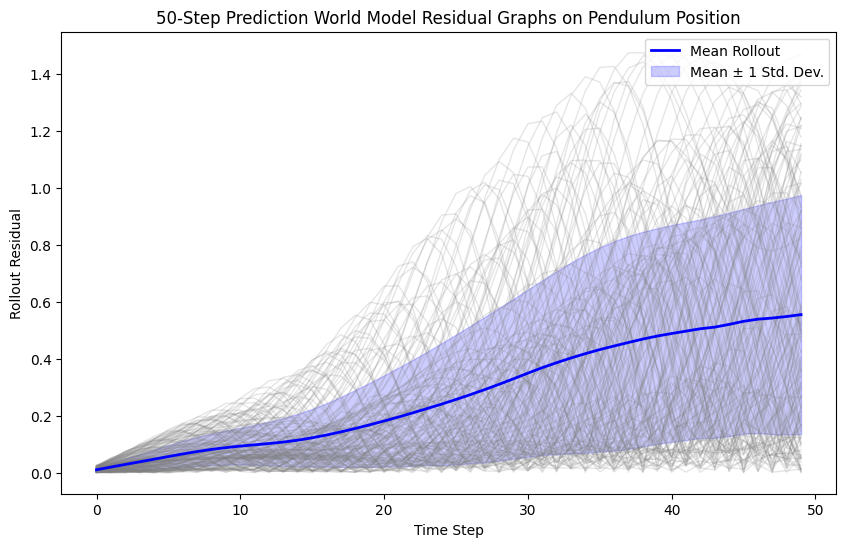

In [31]:
set_of_residuals_x = set_of_residuals[:, :, 0]  # shape (400, 50)

n_rollouts = set_of_residuals_x.shape[0]
n_timesteps = set_of_residuals_x.shape[1]

plt.figure(figsize=(10, 6))

# 1. Plot all rollouts
for r in range(n_rollouts):
    plt.plot(set_of_residuals_x[r], color='gray', alpha=0.2, linewidth=1)

# 2. Compute and plot the mean
mean_rollout = set_of_residuals_x.mean(axis=0)
plt.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')

# 3. Compute and plot ±1 std dev
std_rollout = set_of_residuals_x.std(axis=0)
time_steps = np.arange(n_timesteps)
plt.fill_between(
    time_steps,
    mean_rollout - std_rollout,
    mean_rollout + std_rollout,
    color='blue',
    alpha=0.2,
    label='Mean ± 1 Std. Dev.'
)

# 4. Labels, legend, show
plt.xlabel("Time Step")
plt.ylabel("Rollout Residual")
plt.title("50-Step Prediction World Model Residual Graphs on Pendulum Position")
plt.legend(loc='upper right')
plt.show()

Some more cool graphs

In [67]:
# datapoints
t_old_obs = []
t_actions = []
t_new_obs = []
for _ in range(20):    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        t_old_obs.append(obs)
        t_actions.append(action)
        t_new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

t_old_obs = np.vstack(t_old_obs)
t_actions = np.vstack(t_actions)
t_new_obs = np.vstack(t_new_obs)

test_inputs = np.concatenate((t_old_obs, t_actions), axis=1)
test_inputs = torch.tensor(test_inputs)

t_old_obs.shape

(4000, 3)

In [68]:
with torch.no_grad():
    predictions = world_model(test_inputs)[0].numpy()

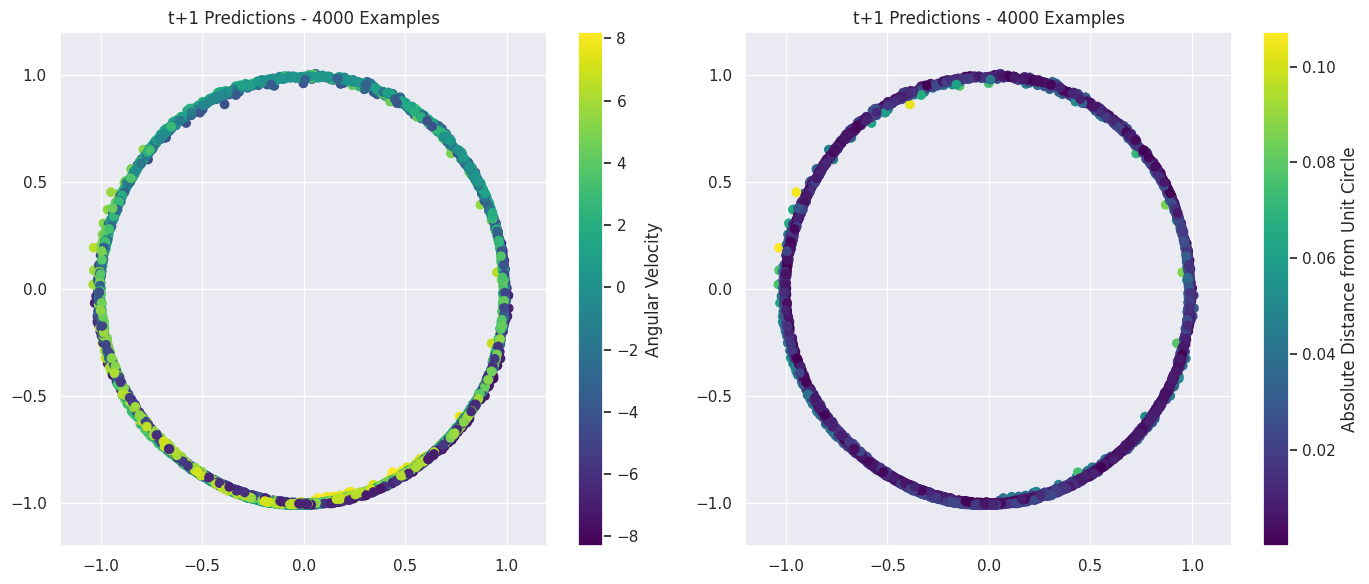

In [69]:
# Graphs of pendulum trajectories
d_unit_circle = np.abs((predictions[:, 1]**2 + predictions[:, 0]**2) - 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=False, sharey=False)

# 1) First Plot: color by predictions[:, 2]
sc1 = axes[0].scatter(predictions[:, 1], predictions[:, 0], 
                      c=predictions[:, 2], cmap='viridis')

axes[0].set_xlim([-1.2, 1.2])
axes[0].set_ylim([-1.2, 1.2])
axes[0].set_title("t+1 Predictions - 4000 Examples")
# Add colorbar for the first plot
cb1 = fig.colorbar(sc1, ax=axes[0])
cb1.set_label("Angular Velocity")


sc2 = axes[1].scatter(predictions[:, 1], predictions[:, 0], 
                      c=d_unit_circle, cmap='viridis')
axes[1].set_xlim([-1.2, 1.2])
axes[1].set_ylim([-1.2, 1.2])
axes[1].set_title("t+1 Predictions - 4000 Examples")
# Add colorbar for the second plot
cb2 = fig.colorbar(sc2, ax=axes[1])
cb2.set_label("Absolute Distance from Unit Circle")

plt.tight_layout()
plt.show()

In [1]:
# Maybe what's next is to plot n-step trajectories?

set_of_residuals = []

set_of_predictions = []

for j in range(10):
    test_horizon = [test_inputs[j*200]]
    rollout_residuals = []
    
    for i in range(150):
        inputs = test_horizon[i].view(1, -1)
        with torch.no_grad():
            prediction = world_model(inputs)[0].numpy()

        # save predictions
        set_of_predictions.append(prediction)

        # get residuals
        residuals = np.abs(np.average(prediction[:, :2] - t_new_obs[j + i, :2], axis=1))
        rollout_residuals.append(residuals)
    
        new_action = np.expand_dims(np.array(t_actions[j + i+1]), axis=0)
        # append output with action
        new_horizon = np.concatenate((prediction, new_action), axis=1)
        test_horizon.append(torch.tensor(new_horizon))
        
    rollout_residuals = np.vstack(rollout_residuals)
    set_of_residuals.append(rollout_residuals)
    

NameError: name 'test_inputs' is not defined

In [2]:
set_of_predictions = np.stack(set_of_predictions)
set_of_predictions = np.squeeze(set_of_predictions, axis=1)
set_of_predictions.shape

NameError: name 'np' is not defined

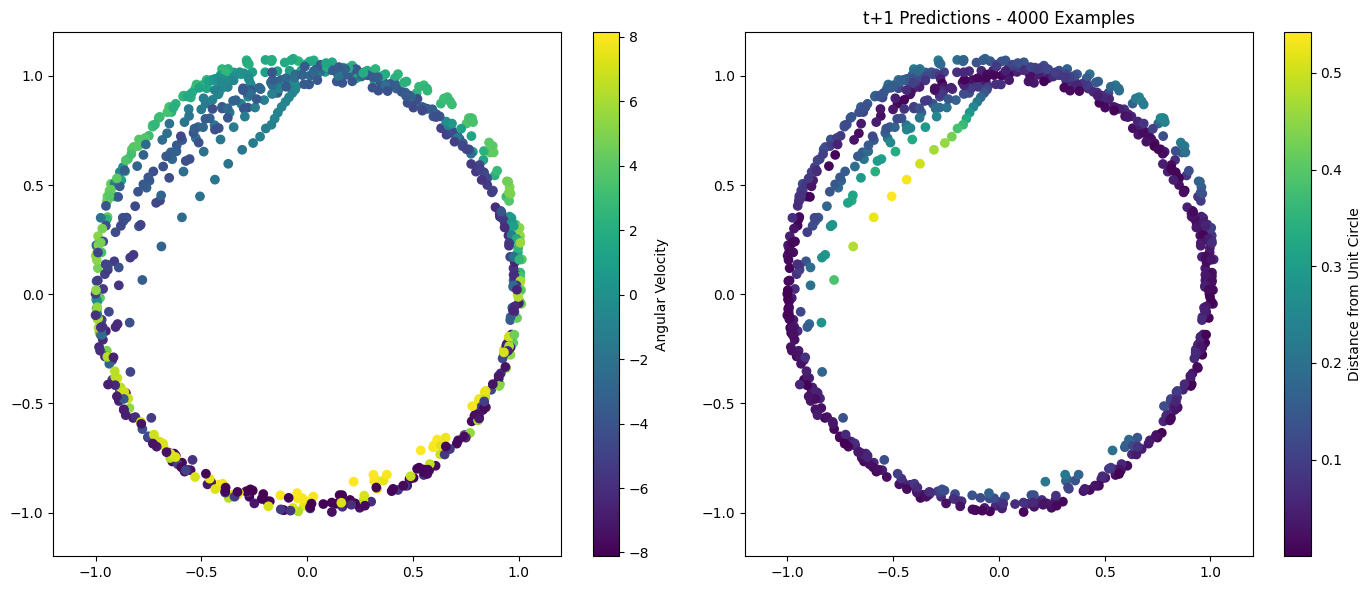

In [47]:
d_unit_circle = np.abs((set_of_predictions[:, 1]**2 + set_of_predictions[:, 0]**2) - 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=False, sharey=False)

# 1) First Plot: color by predictions[:, 2]
sc1 = axes[0].scatter(set_of_predictions[:, 1], set_of_predictions[:, 0], 
                      c=set_of_predictions[:, 2], cmap='viridis')

axes[0].set_xlim([-1.2, 1.2])
axes[0].set_ylim([-1.2, 1.2])
axes[0].set_title("")
# Add colorbar for the first plot
cb1 = fig.colorbar(sc1, ax=axes[0])
cb1.set_label("Angular Velocity")


sc2 = axes[1].scatter(set_of_predictions[:, 1], set_of_predictions[:, 0], 
                      c=d_unit_circle, cmap='viridis')
axes[1].set_xlim([-1.2, 1.2])
axes[1].set_ylim([-1.2, 1.2])
axes[1].set_title("t+1 Predictions - 4000 Examples")
# Add colorbar for the second plot
cb2 = fig.colorbar(sc2, ax=axes[1])
cb2.set_label("Distance from Unit Circle")

plt.tight_layout()
plt.show()

# World Model - Out of Distribution

Testing world models on rollouts achieved by the agent.

In [252]:
import gym
num_rollouts = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")

In [414]:
inputs, outputs = get_rnd_wm_samples(env, num_rollouts)

In [415]:
# Suppose for whatever reason that one of the outputs being at a different order of magnitude messes with the model. Let's change that 

angular_velocity = 2
max_angular_velocity_magnitude = 8

print("Max and Min Values respectively for environment's angular velocity", max(inputs[:, angular_velocity]), min(inputs[:, angular_velocity]))

# Scale inputs
inputs[:, angular_velocity] = inputs[:, angular_velocity]/max_angular_velocity_magnitude

# Scale outputs
outputs[:, angular_velocity] = outputs[:, angular_velocity]/max_angular_velocity_magnitude

print("Max and Min Values respectively for environment's angular velocity after scaling", max(inputs[:, angular_velocity]), min(inputs[:, angular_velocity]))

Max and Min Values respectively for environment's angular velocity 8.0 -8.0
Max and Min Values respectively for environment's angular velocity after scaling 1.0 -1.0


In [422]:
# Add noise
noise = np.concatenate([np.random.randn(20000,3)*0.1, np.zeros((20000, 1))], axis=1)
inputs = inputs + noise
print(inputs.shape)

(20000, 4)


In [423]:

inputs = torch.tensor(inputs, dtype=torch.float32)
outputs = torch.tensor(outputs, dtype=torch.float32)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, residual_outputs), batch_size=128, shuffle=True, num_workers=8
)

In [440]:
out_features = 3
in_features = 4

wiring = AutoNCP(24, out_features)  

world_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=35,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


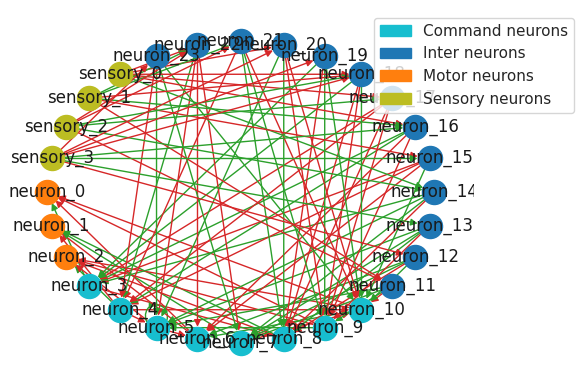

In [441]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()# Let's visualize how LTC initialy performs before the training
sns.set()

In [442]:
trainer.fit(learn, dataloader)


  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 2.2 K  | train
---------------------------------------
1.8 K     Trainable params
422       Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=35` reached.


## Baseline - Residuals from In Distribution Data

In [443]:
t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs.shape
t_a.shape

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude

inputs = np.concatenate((t_obs, t_a), axis=2)
inputs.shape

(50, 200, 4)

In [444]:
set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # add residuals
    prediction = c_inputs[:, :3] + torch.FloatTensor(prediction)
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_n_obs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_n_obs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_n_obs[:, i, 2]*max_angular_velocity_magnitude)

x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T

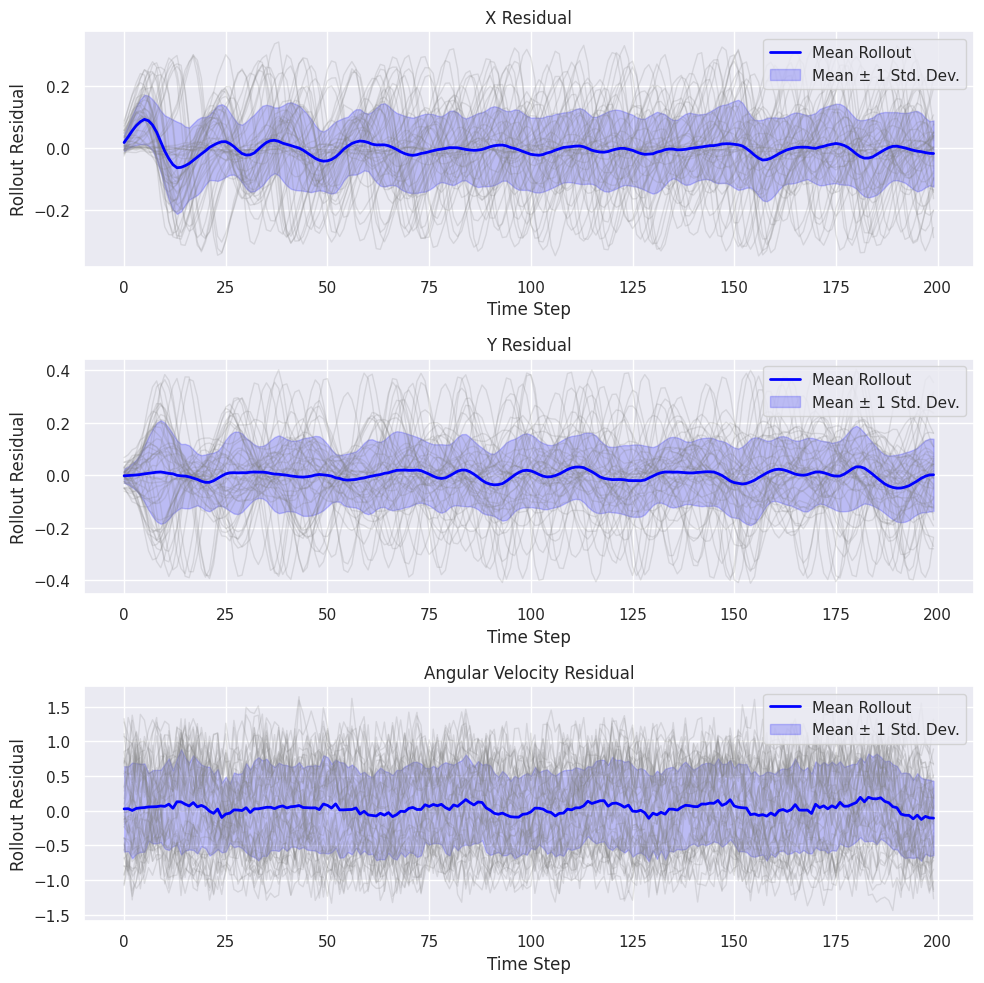

In [445]:

sns.set()

# Assuming these are already defined and have shape (50, 200)
# x_res = np.vstack(x_residuals).T
# y_res = np.vstack(y_residuals).T
# ang_res = np.vstack(ang_vel_residuals).T

# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


In [446]:
set_of_predictions = np.stack(set_of_predictions)
set_of_predictions = set_of_predictions.reshape([200*50, 3])

(10000, 3)   (10000, 3)


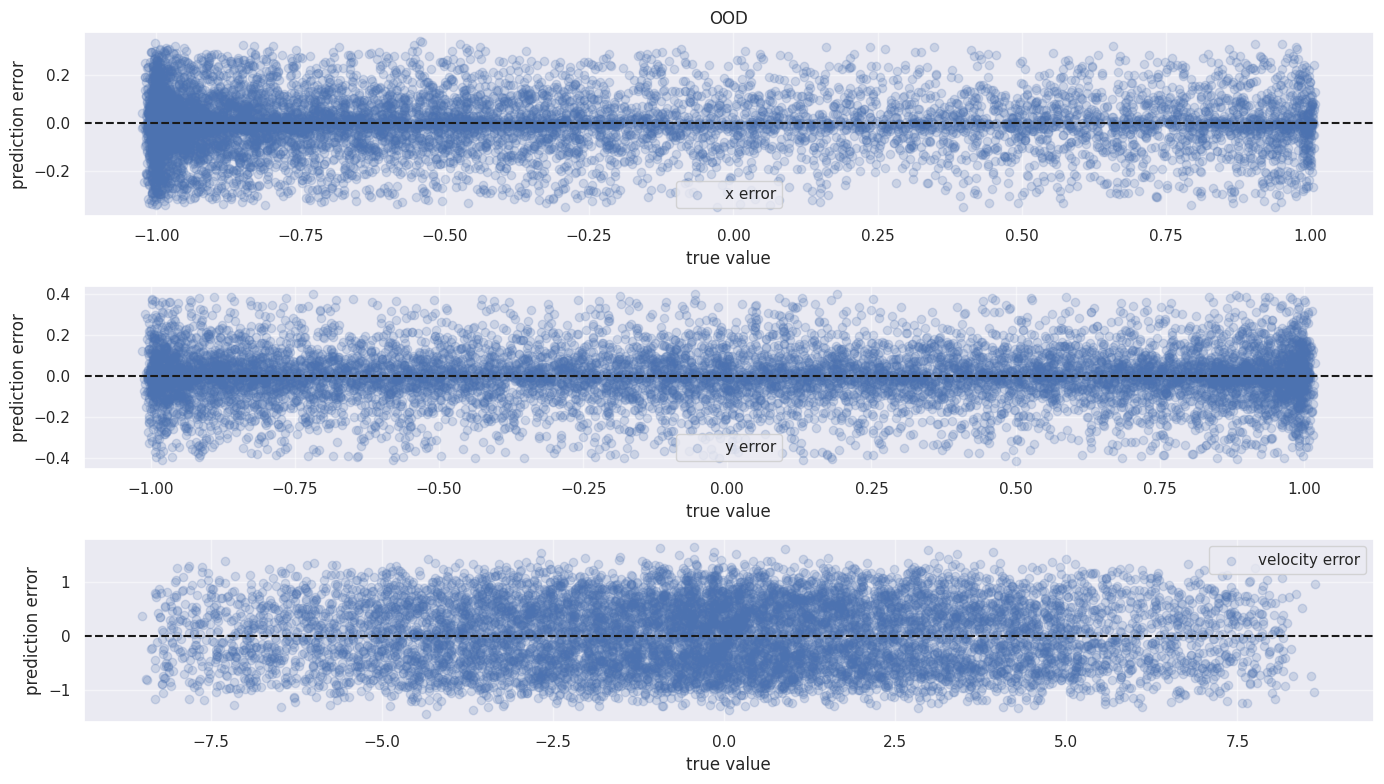

In [447]:

def residual_plot(outputs: np.array, residuals:np.array, title:str) -> None:
    fig,ax = plt.subplots(3,1,figsize=(14,8))
    ax[0].set_title(title)
    ax[0].scatter(outputs[:,0],residuals[:,0],label='x error',alpha=0.2)
    ax[1].scatter(outputs[:,1],residuals[:,1],label='y error',alpha=0.2)
    ax[2].scatter(outputs[:,2]*max_angular_velocity_magnitude,residuals[:,2],label='velocity error',alpha=0.2)
    for i in range(3):
      ax[i].legend()
      ax[i].grid(alpha=0.5)
      ax[i].axhline(0,ls='--',c='k')
      ax[i].set_xlabel('true value')
      ax[i].set_ylabel('prediction error')
    plt.tight_layout()

residuals = np.array([x_res.flatten(), y_res.flatten(), ang_res.flatten()]).T
#residual_plot(outputs, krr.predict(inputs) - outputs, title = 'KRR')

#residuals.shape
#set_of_predictions = set_of_predictions.reshape([200*50, 3])
print(set_of_predictions.shape, " ", residuals.shape)

residual_plot(set_of_predictions, residuals , title = 'OOD')

## One Step Residuals with Out Of Distribution Data

In [178]:
from baseline import train_ppo

env_name = "Pendulum-v1"
agent = train_ppo(env_name)

actionspace: 1, obs space 3
Learning... Running 200 timesteps per episode, 5 timesteps per batch for a total of 400 rollouts



Rollouts: 100%|████████████████████████████████████████████████████████████| 400/400 [04:02<00:00,  1.65it/s, loss=-646]


In [179]:
from baseline import test_ppo

test_ppo(agent, env_name)

In [180]:
# Okay, model works. Let's get a couple trajectories from the model.

t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action, log_prob = agent.get_action(v_obs)
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude


#inputs = np.concatenate((t_obs, t_a), axis=1)
#inputs.shape

In [181]:
t_obs.shape
t_a.shape
inputs = np.concatenate((t_obs, t_a), axis=2)
inputs.shape

(50, 200, 4)

In [182]:
set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_n_obs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_n_obs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_n_obs[:, i, 2]*max_angular_velocity_magnitude)
    
    #set_of_residuals.append(np.abs(np.average(prediction[:, :] - t_n_obs[:, i, :], axis=1)))


In [183]:
x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T

ang_res.shape

(50, 200)

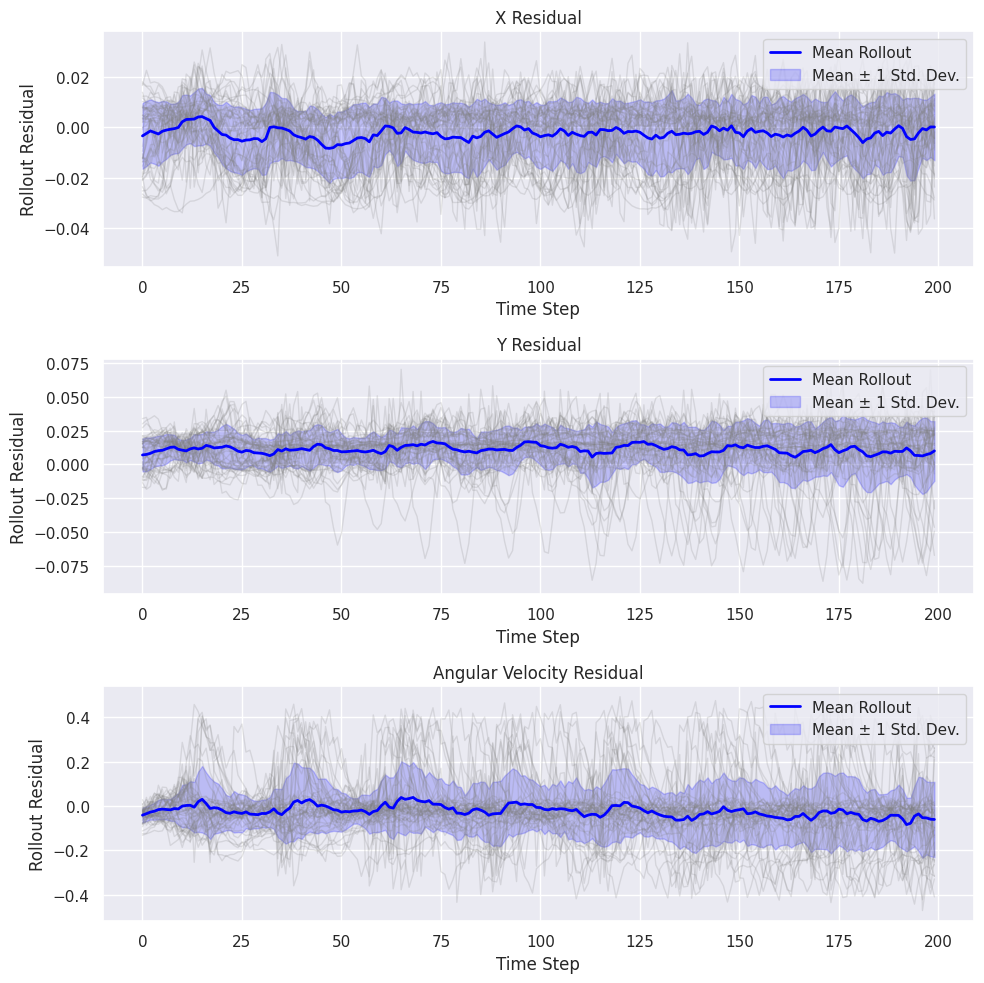

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Assuming these are already defined and have shape (50, 200)
# x_res = np.vstack(x_residuals).T
# y_res = np.vstack(y_residuals).T
# ang_res = np.vstack(ang_vel_residuals).T

# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


In [185]:
set_of_predictions = np.stack(set_of_predictions)
set_of_predictions.shape

pen_len = set_of_predictions[:, :, 0]**2 + set_of_predictions[:, :, 1]**2
pen_len = pen_len.T
pen_len.shape

(50, 200)

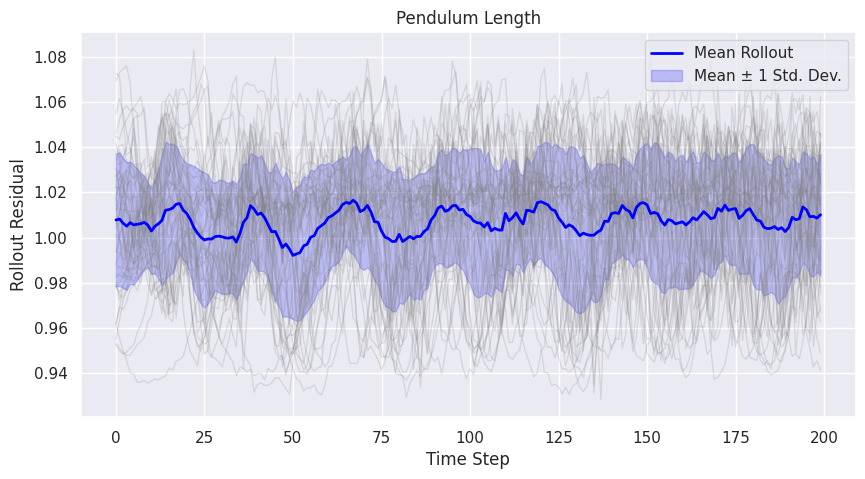

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
time_steps = np.arange(200)
plot_residuals(axes, pen_len, "Pendulum Length")

In [187]:
set_of_predictions = set_of_predictions.reshape([200*50, 3])

(10000, 3)   (10000, 3)


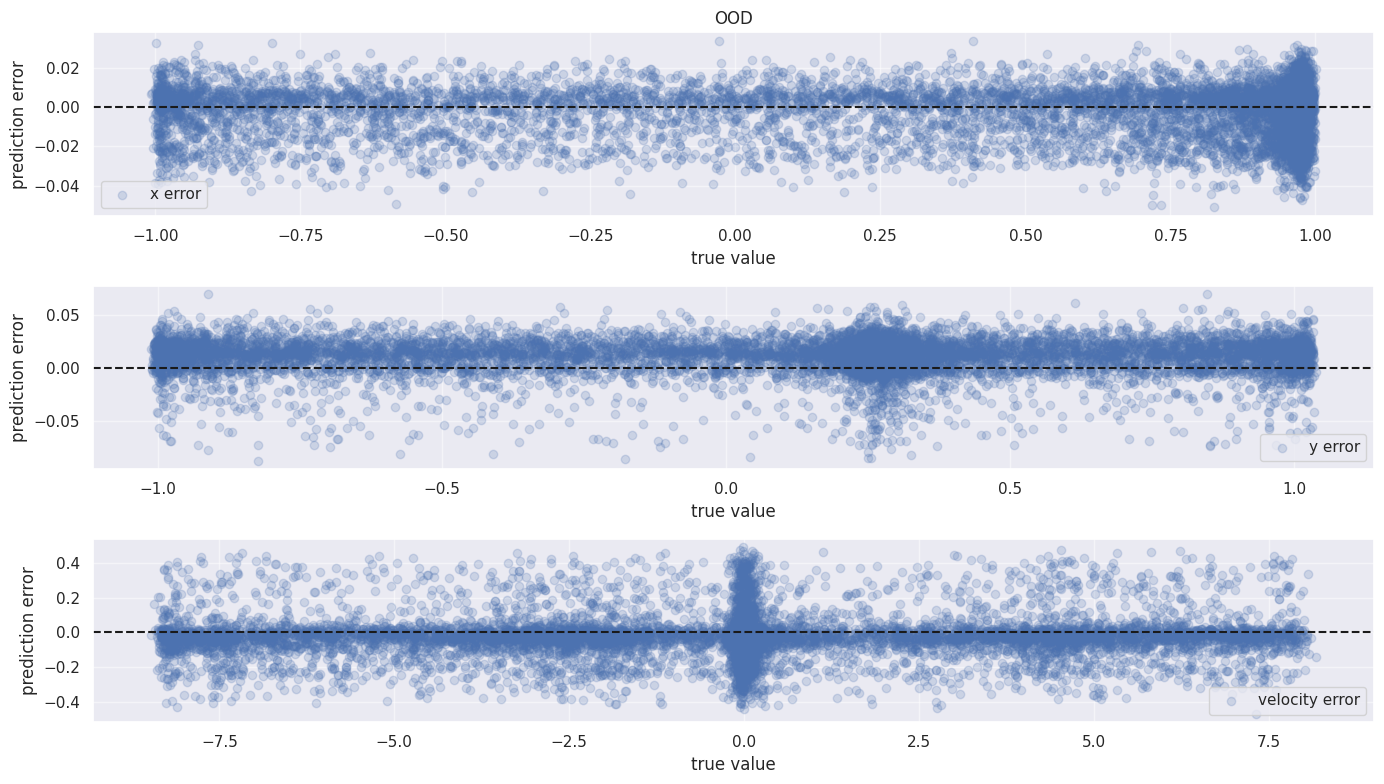

In [189]:
# Thanks finn!

def residual_plot(outputs: np.array, residuals:np.array, title:str) -> None:
    fig,ax = plt.subplots(3,1,figsize=(14,8))
    ax[0].set_title(title)
    ax[0].scatter(outputs[:,0],residuals[:,0],label='x error',alpha=0.2)
    ax[1].scatter(outputs[:,1],residuals[:,1],label='y error',alpha=0.2)
    ax[2].scatter(outputs[:,2]*max_angular_velocity_magnitude,residuals[:,2],label='velocity error',alpha=0.2)
    for i in range(3):
      ax[i].legend()
      ax[i].grid(alpha=0.5)
      ax[i].axhline(0,ls='--',c='k')
      ax[i].set_xlabel('true value')
      ax[i].set_ylabel('prediction error')
    plt.tight_layout()


residuals = np.array([x_res.flatten(), y_res.flatten(), ang_res.flatten()]).T
#residual_plot(outputs, krr.predict(inputs) - outputs, title = 'KRR')

#residuals.shape
print(set_of_predictions.shape, " ", residuals.shape)

residual_plot(set_of_predictions, residuals , title = 'OOD')

## 50 Step Residuals

Get multi-step residuals on random and PPO rollout.

In [210]:
# inputs have 0-2 as state and 3 as action. 

# PPO rollout comes first because it's the most recently worked with data

set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = torch.FloatTensor(time_horizon[-1])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_n_obs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_n_obs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_n_obs[:, i, 2]*max_angular_velocity_magnitude)

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)


x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T

ang_res.shape

(50, 150)

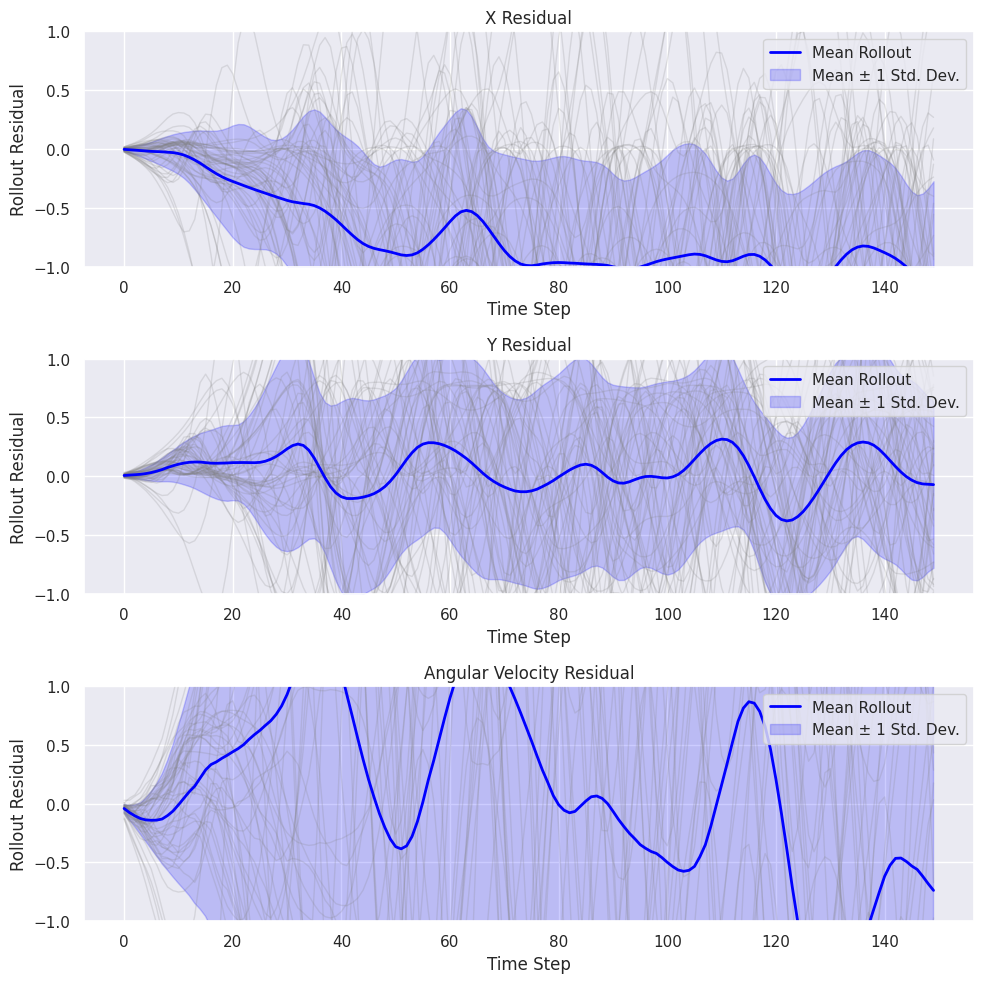

In [211]:
# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    ax.set_ylim(-1, 1)
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


In [212]:
# Now for random samples

t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs.shape
t_a.shape

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude

inputs = np.concatenate((t_obs, t_a), axis=2)
inputs.shape

(50, 200, 4)

In [216]:
# inputs have 0-2 as state and 3 as action. 

# PPO rollout comes first because it's the most recently worked with data

set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = torch.FloatTensor(time_horizon[-1])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_n_obs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_n_obs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_n_obs[:, i, 2]*max_angular_velocity_magnitude)

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)


x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T

ang_res.shape

(50, 150)

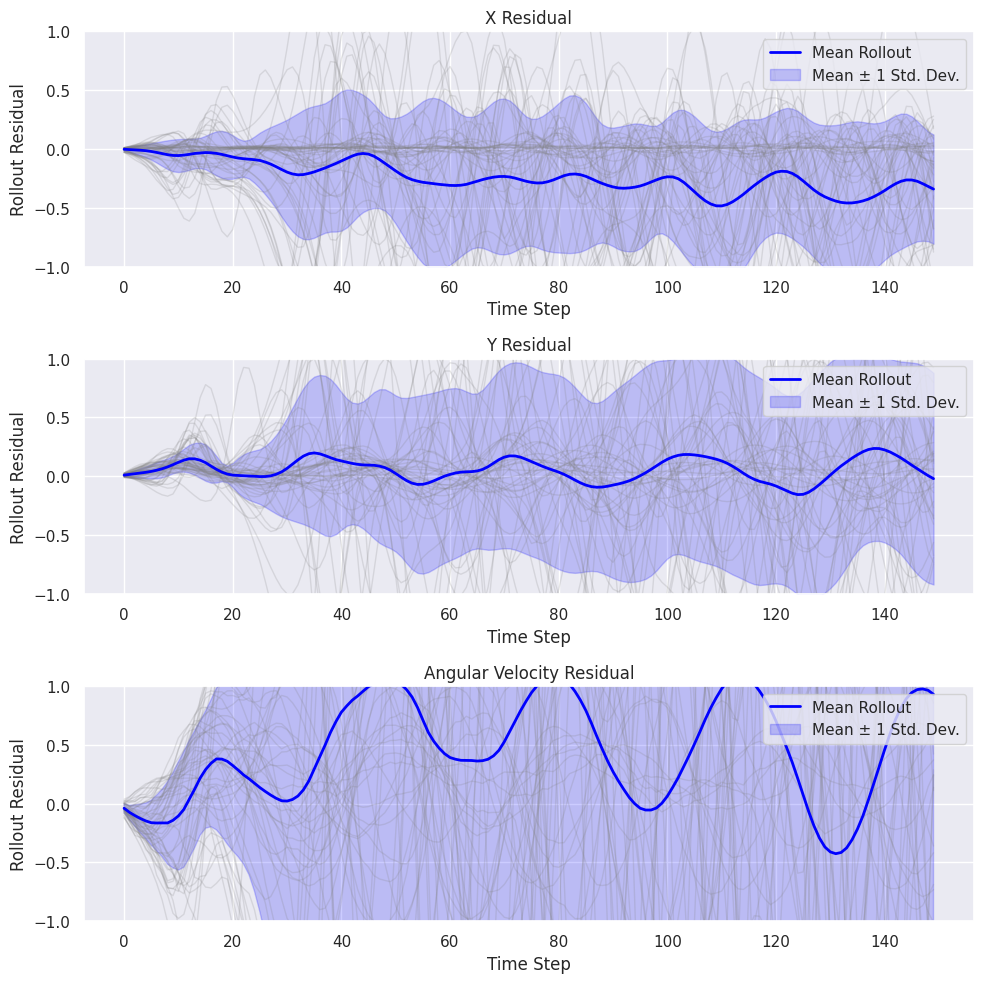

In [220]:
# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    ax.set_ylim(-1, 1)
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


# Neural ODES

In [227]:
device = 'cpu'
class NeuralODE(nn.Module):
    '''
    Neural ODE's are still neural networks. The challenge is to find out where they differ.
    '''
    def __init__(self, input_dims, output_dims):
        super(NeuralODE, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


        self.net = nn.Sequential(
            nn.Linear(self.input_dims, 64),
            #nn.Tanh(),
            nn.Linear(64, 64),
            #nn.Tanh(),
            nn.Linear(64, self.output_dims)
        ).to(device)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)


    def forward(self, t, x):
        return self.net(x)

In [250]:
inputs, outputs = get_rnd_wm_samples(env, num_rollouts)
print(inputs.shape, " ", outputs.shape)


# Scale inputs
inputs[:, angular_velocity] = inputs[:, angular_velocity]/max_angular_velocity_magnitude

# Scale outputs
outputs[:, angular_velocity] = outputs[:, angular_velocity]/max_angular_velocity_magnitude

zeros = np.ones((20000, 1))
outputs = np.concatenate((outputs, zeros), axis=1)

print(outputs.shape)

inputs = torch.tensor(inputs, dtype=torch.float32)
outputs = torch.tensor(outputs, dtype=torch.float32)


(20000, 4)   (20000, 3)
(20000, 4)


In [251]:
from torchdiffeq import odeint, odeint_adjoint
epochs = 20
t_axis = np.arange(0, 20000, 1)
t_axis = torch.tensor(t_axis, dtype=torch.float32)

fx = NeuralODE(4, 4)

for e in range(epochs):
  foresight_int = 15

  for i in range(inputs.shape[0]):
    fx.net.zero_grad()
    input_s = inputs[i, :]
    print("Input has size: ", input_s.shape)
    output = odeint(fx, input_s, t_axis)
    loss = T.mean((outputs[i] - output)**2)
    loss.backward()
    fx.optimizer.step()


Input has size:  torch.Size([4])


AssertionError: underflow in dt 0.0